# Overview
Copy from https://www.kaggle.com/kmader/quickdraw-with-wavenet-classifier/data
The notebook is modified from one that was made for the [Quick, Draw Dataset](https://www.kaggle.com/google/tinyquickdraw), it would actually be interesting to see how beneficial a transfer learning approach using that data as a starting point could be.

## This Notebook
The notebook takes and preprocesses the data from the QuickDraw Competition step (strokes) and trains an a WaveNet-style classifier (wavenet in its original implemention is https://deepmind.com/blog/high-fidelity-speech-synthesis-wavenet/ is intended for synthesis, but the dilated convolution approach can be applied). We use the implementation [here](https://github.com/mjpyeon/wavenet-classifier/blob/master/WaveNetClassifier.py) as a reference.

## Fun Models

After the classification models, we try to build a few models to understand what the WaveNet actually does. Here we experiment step by step to see how the prediction changes with each stop

### Next Steps
The next steps could be
- use more data to train
- include the country code (different countries draw different things, different ways)
- more complex models

## setting
set KERAS_BACKEND=tensorflow

### Model Parameters
Here we keep all of the parameters to make keeping track of versions and hyperparameter optimization  easier

In [1]:
%matplotlib inline
import os
import sys
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn import preprocessing
from keras.utils.np_utils import to_categorical

from keras.preprocessing.sequence import pad_sequences
from sklearn.preprocessing import LabelEncoder
import pandas as pd
from keras.metrics import top_k_categorical_accuracy
def top_3_accuracy(x,y): return top_k_categorical_accuracy(x,y, 3)
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping, ReduceLROnPlateau
from glob import glob
import gc
gc.enable()
def get_available_gpus():
    from tensorflow.python.client import device_lib
    local_device_protos = device_lib.list_local_devices()
    return [x.name for x in local_device_protos if x.device_type == 'GPU']
base_dir = os.path.join( 'input')
test_path = os.path.join(base_dir, 'test_simplified.csv')

Using TensorFlow backend.


In [2]:
xfile = 'F:\workspace\j6stock\XOpenHighLowCloseVol_tp10_cl10.txt'
seq_len = 300

n_filters = 32 #64
dilation_depth = 8
activation = 'softmax'
scale_ratio = 1
kernel_size = 2
pool_size_1 = 4
pool_size_2 = 8
batch_size = 4096 #batch_size = 4096
STROKE_COUNT = 196
TRAIN_SAMPLES = 750
VALID_SAMPLES = 75
TEST_SAMPLES = 50

In [3]:
from ast import literal_eval
ALL_TRAIN_PATHS = glob(os.path.join(base_dir, 'train_simplified', '*.csv'))
COL_NAMES = ['countrycode', 'drawing', 'key_id', 'recognized', 'timestamp', 'word']

# def _stack_it(raw_strokes):
#     """preprocess the string and make 
#     a standard Nx3 stroke vector"""
#     stroke_vec = literal_eval(raw_strokes) # string->list
#     # unwrap the list
#     in_strokes = [(xi,yi,i)  
#      for i,(x,y) in enumerate(stroke_vec) 
#      for xi,yi in zip(x,y)]
#     c_strokes = np.stack(in_strokes)
#     # replace stroke id with 1 for continue, 2 for new
#     c_strokes[:,2] = [1]+np.diff(c_strokes[:,2]).tolist()
#     c_strokes[:,2] += 1 # since 0 is no stroke
#     # pad the strokes with zeros
#     return pad_sequences(c_strokes.swapaxes(0, 1), 
#                          maxlen=STROKE_COUNT, 
#                          padding='post').swapaxes(0, 1)
# def read_batch(samples=5, 
#                start_row=0,
#                max_rows=1000):
#     """
#     load and process the csv files
#     this function is horribly inefficient but simple
#     """
#     out_df_list = []
#     for c_path in ALL_TRAIN_PATHS:
#         c_df = pd.read_csv(c_path, nrows=max_rows, skiprows=start_row)
#         c_df.columns=COL_NAMES
#         out_df_list += [c_df.sample(samples)[['drawing', 'word']]]
#     full_df = pd.concat(out_df_list)
#     full_df['drawing'] = full_df['drawing'].\
#         map(_stack_it)
    
#     return full_df


def get_stock_data(normalize=True, ma=[]):
    """
    Return a dataframe of that stock and normalize all the values. 
    (Optional: create moving average)
    """
    df = pd.read_csv(filepath_or_buffer  = xfile )
    #TODO Use previous close instead of open
    df['change'] = df['close'] - df['open']
    for i, row in df.iterrows():
        df.at[i, 'high'] = df.at[i, 'high'] - (df.at[i, 'open'] if df.at[i, 'open'] > df.at[i, 'close'] else df.at[i, 'close'])
        df.at[i, 'low'] = (df.at[i, 'close'] if df.at[i, 'close'] < df.at[i, 'open'] else df.at[i, 'open']) - df.at[i, 'low']
    df.dropna(inplace=True)
    df = df.drop('open', axis=1)
    # Moving Average    
    if ma != []:
        for moving in ma:
            df['{}ma'.format(moving)] = df['close'].rolling(window=moving).mean()
    df.dropna(inplace=True)
    if normalize:
        min_max_scaler = preprocessing.MinMaxScaler()
        #df['open'] = min_max_scaler.fit_transform(df.open.values.reshape(-1,1))
        #df['high'] = min_max_scaler.fit_transform(df.high.values.reshape(-1,1))
        #df['low'] = min_max_scaler.fit_transform(df.low.values.reshape(-1,1))
        #df['vol'] = min_max_scaler.fit_transform(df.vol.values.reshape(-1,1))
        df['close'] = min_max_scaler.fit_transform(df['close'].values.reshape(-1,1))
        #df['change'] = min_max_scaler.fit_transform(df['change'].values.reshape(-1,1))
        if ma != []:
            for moving in ma:
                df['{}ma'.format(moving)] = min_max_scaler.fit_transform(df['{}ma'.format(moving)].values.reshape(-1,1))  
    df.dropna(inplace=True)
               
    # Move y_result to the rightmost for the ease of training
    adj_close = df['y_result']
    df.drop(labels=['y_result'], axis=1, inplace=True)
    df = pd.concat([df, adj_close], axis=1)
    
    #drop for wavenet and not enough memory
    df.drop(labels=['change'], axis=1, inplace=True)
    df.drop(labels=['high'], axis=1, inplace=True)
    df.drop(labels=['low'], axis=1, inplace=True)
    
    return df

#df = get_stock_data( ma=[50, 100, 200])
df = get_stock_data()

amount_of_features = len(df.columns)-1

def load_data(stock, seq_len):
    print ("Amount of features = {}".format(amount_of_features))
    data = stock.as_matrix()
    sequence_length = seq_len + 1 # index starting from 0
    x_result = []
    y_result = []
    for index in range(seq_len, len(data) ): # maxmimum date = lastest date - sequence length
        x_result.append(data[index-seq_len: index,:-1]) # index : index + 22days
        y_result.append(data[index ,amount_of_features]);

    #print('---', data[0])
    #print('---', x_result[0])
    #print('---', y_result[0])
    x_result = np.array(x_result)
    y_result = np.array(y_result)
    row = round(0.6 * y_result.shape[0]) # 80% split
    print ("Amount of training data = {}".format(0.9 * x_result.shape[0]))
    print ("Amount of testing data = {}".format(0.1 * y_result.shape[0]))
     
    X_train = x_result[:int(row), :] # 90% date
    y_train = y_result[:int(row)] # 90% date
        

    X_test = x_result[int(row):, :]
    y_test = y_result[int(row):]
    # filter for 1 and -1 for validation only
    X_test = X_test[y_test[:]!=0,:]
    y_test = y_test[y_test[:]!=0]
    #print(result.shape[0], len(y_result), int(row), y_result[int(row):])
    #X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], amount_of_features-1))
    #X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], amount_of_features-1))
    
    return [X_train, y_train, X_test, y_test]



# Reading and Parsing
Since it is too much data (23GB) to read in at once, we just take a portion of it for training, validation and hold-out testing. This should give us an idea about how well the model works, but leaves lots of room for improvement later

In [4]:
classes = [1, 0, -1]
lb = preprocessing.LabelBinarizer()
lb.fit(classes)

X_tr, lab_tr, X_vld, lab_vld = load_data(df, seq_len)
y_tr = lb.transform(lab_tr)
y_vld = lb.transform(lab_vld)


# train_args = dict(samples=TRAIN_SAMPLES, 
#                   start_row=0, 
#                   max_rows=int(TRAIN_SAMPLES*1.5))
# valid_args = dict(samples=VALID_SAMPLES, 
#                   start_row=train_args['max_rows']+1, 
#                   max_rows=VALID_SAMPLES+25)
# test_args = dict(samples=TEST_SAMPLES, 
#                  start_row=valid_args['max_rows']+train_args['max_rows']+1, 
#                  max_rows=TEST_SAMPLES+25)
# train_df = read_batch(**train_args)
# valid_df = read_batch(**valid_args)
# test_df = read_batch(**test_args)
# word_encoder = LabelEncoder()
# word_encoder.fit(train_df['word'])
# print('words', len(word_encoder.classes_), '=>', ', '.join([x for x in word_encoder.classes_]))

Amount of features = 1
Amount of training data = 261936.0
Amount of testing data = 29104.0


# Stroke-based Classification
Here we use the stroke information to train a model and see if the strokes give us a better idea of what the shape could be. 

In [5]:

train_X = X_tr
train_y = y_tr
valid_X = X_vld
valid_y = y_vld
test_X = X_vld
test_y = y_vld
print(train_X.shape)
print(train_y[0])

(174624, 300, 1)
[0 1 0]


IndexError: index 2 is out of bounds for axis 1 with size 1

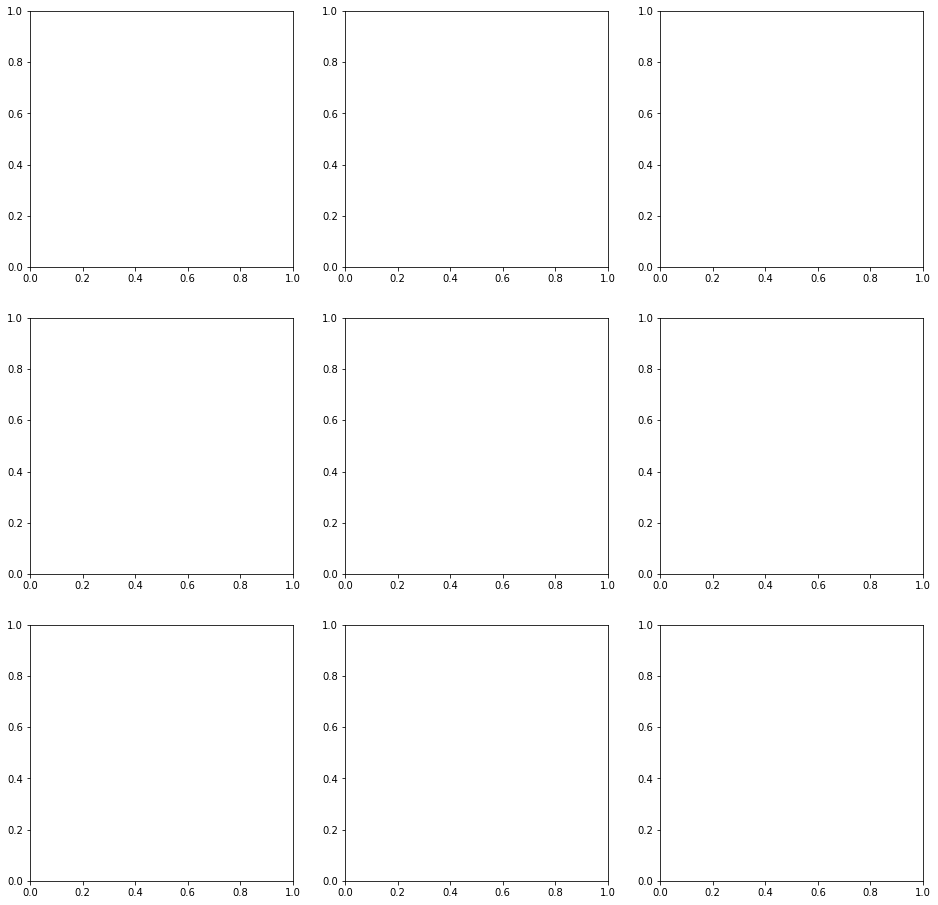

In [6]:
# fig, m_axs = plt.subplots(3,3, figsize = (16, 16))
# rand_idxs = np.random.choice(range(train_X.shape[0]), size = 9)
# for c_id, c_ax in zip(rand_idxs, m_axs.flatten()):
#     test_arr = train_X[c_id]
#     test_arr = test_arr[test_arr[:,2]>0, :] # only keep valid points
#     lab_idx = np.cumsum(test_arr[:,2]-1)
#     for i in np.unique(lab_idx):
#         c_ax.plot(test_arr[lab_idx==i,0], 
#                 np.max(test_arr[:,1])-test_arr[lab_idx==i,1], '.-')
#     c_ax.axis('off')
    #c_ax.set_title(word_encoder.classes_[np.argmax(train_y[c_id])])

# WaveNet to Parse Strokes
The model suggeted from the WaveNet article by DeepMind (taken from site mentioned above) is

![Suggested Model](https://storage.googleapis.com/deepmind-live-cms/documents/wavenet_conv_gif.gif)

In [7]:
from keras.layers import Conv1D, Input, Activation, AveragePooling1D, Add, Multiply, GlobalAveragePooling1D
from keras.models import Model
input_shape = train_X.shape[1:]
output_shape = train_y.shape[1:]
def residual_block(x, i):
    tanh_out = Conv1D(n_filters, 
                      kernel_size, 
                      dilation_rate = kernel_size**i, 
                      padding='causal', 
                      name='dilated_conv_%d_tanh' % (kernel_size ** i), 
                      activation='tanh'
                      )(x)
    sigm_out = Conv1D(n_filters, 
                      kernel_size, 
                      dilation_rate = kernel_size**i, 
                      padding='causal', 
                      name='dilated_conv_%d_sigm' % (kernel_size ** i), 
                      activation='sigmoid'
                      )(x)
    z = Multiply(name='gated_activation_%d' % (i))([tanh_out, sigm_out])
    skip = Conv1D(n_filters, 1, name='skip_%d'%(i))(z)
    res = Add(name='residual_block_%d' % (i))([skip, x])
    return res, skip
x = Input(shape=input_shape, name='original_input')
skip_connections = []
out = Conv1D(n_filters, 2, dilation_rate=1, padding='causal', name='dilated_conv_1')(x)
for i in range(1, dilation_depth + 1):
    out, skip = residual_block(out,i)
    skip_connections.append(skip)
out = Add(name='skip_connections')(skip_connections)
out = Activation('relu')(out)

out = Conv1D(n_filters, pool_size_1, strides = 1, padding='same', name='conv_5ms', activation = 'relu')(out)
out = AveragePooling1D(pool_size_1, padding='same', name='downsample_to_200Hz')(out)

out = Conv1D(n_filters, pool_size_2, padding='same', activation='relu', name='conv_500ms')(out)
out = Conv1D(output_shape[0], pool_size_2, padding='same', activation='relu', name='conv_500ms_target_shape')(out)
out = AveragePooling1D(pool_size_2, padding='same',name = 'downsample_to_2Hz')(out)
out = Conv1D(output_shape[0], (int) (input_shape[0] / (pool_size_1*pool_size_2)), padding='same', name='final_conv')(out)
out = GlobalAveragePooling1D(name='final_pooling')(out)
out = Activation(activation, name='final_activation')(out)

stroke_read_model = Model(x, out)  
stroke_read_model.compile(optimizer='adam', 
                          loss='categorical_crossentropy', 
                          metrics=['accuracy', top_3_accuracy])
stroke_read_model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
original_input (InputLayer)     (None, 300, 1)       0                                            
__________________________________________________________________________________________________
dilated_conv_1 (Conv1D)         (None, 300, 32)      96          original_input[0][0]             
__________________________________________________________________________________________________
dilated_conv_2_tanh (Conv1D)    (None, 300, 32)      2080        dilated_conv_1[0][0]             
__________________________________________________________________________________________________
dilated_conv_2_sigm (Conv1D)    (None, 300, 32)      2080        dilated_conv_1[0][0]             
__________________________________________________________________________________________________
gated_acti

In [8]:
weight_path="{}_weights.best.hdf5".format('stroke_lstm_model')

checkpoint = ModelCheckpoint(weight_path, monitor='val_loss', verbose=1, 
                             save_best_only=True, mode='min', save_weights_only = True)


reduceLROnPlat = ReduceLROnPlateau(monitor='val_loss', factor=0.8, patience=10, verbose=1, mode='auto', epsilon=0.0001, cooldown=5, min_lr=0.001)
early = EarlyStopping(monitor="val_loss", 
                      mode="min", 
                      patience=5) # probably needs to be more patient, but kaggle time is limited
callbacks_list = [checkpoint, early, reduceLROnPlat]

In [11]:
from IPython.display import clear_output
stroke_read_model.fit(train_X, train_y,
                      validation_data = (valid_X, valid_y), 
                      batch_size = batch_size,
                      epochs = 50,
                      callbacks = callbacks_list)
#clear_output()

Train on 174624 samples, validate on 70634 samples
Epoch 1/50
174624/174624 [==============================] - 2125s 12ms/step - loss: 1.0329 - acc: 0.4637 - top_3_accuracy: 1.0000 - val_loss: 1.0973 - val_acc: 0.3401 - val_top_3_accuracy: 1.0000

Epoch 00001: val_loss improved from 1.10044 to 1.09727, saving model to stroke_lstm_model_weights.best.hdf5
Epoch 2/50
174624/174624 [==============================] - 1995s 11ms/step - loss: 1.0259 - acc: 0.4695 - top_3_accuracy: 1.0000 - val_loss: 1.1476 - val_acc: 0.3455 - val_top_3_accuracy: 1.0000

Epoch 00002: val_loss did not improve
Epoch 3/50
174624/174624 [==============================] - 2847s 16ms/step - loss: 1.0220 - acc: 0.4724 - top_3_accuracy: 1.0000 - val_loss: 1.1339 - val_acc: 0.3619 - val_top_3_accuracy: 1.0000

Epoch 00003: val_loss did not improve
Epoch 4/50
174624/174624 [==============================] - 2326s 13ms/step - loss: 1.0152 - acc: 0.4773 - top_3_accuracy: 1.0000 - val_loss: 1.1357 - val_acc: 0.3617 - val_t

In [ ]:
stroke_read_model.load_weights(weight_path)
lstm_results = stroke_read_model.evaluate(test_X, test_y, batch_size = 4096)
print('Accuracy: %2.1f%%, Top 3 Accuracy %2.1f%%' % (100*lstm_results[1], 100*lstm_results[2]))

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
test_cat = np.argmax(test_y, 1)
pred_y = stroke_read_model.predict(test_X, batch_size = 4096)
pred_cat = np.argmax(pred_y, 1)
plt.matshow(confusion_matrix(test_cat, pred_cat))
print(classification_report(test_cat, pred_cat, 
                            target_names = [x for x in ['1', '0', '-1']]))

# Reading Point by Point

In [ ]:
classes = [1, 0, -1]
points_to_use = [5, 15, 20, 30, 40, 50]
points_to_user = [108]
samples = 12
word_dex = lambda x: classes[x]
rand_idxs = np.random.choice(range(test_X.shape[0]), size = samples)
fig, m_axs = plt.subplots(len(rand_idxs), len(points_to_use), figsize = (24, samples/8*24))
for c_id, c_axs in zip(rand_idxs, m_axs):
    res_idx = np.argmax(test_y[c_id])
    goal_cat = classes[res_idx]
    
    for pt_idx, (pts, c_ax) in enumerate(zip(points_to_use, c_axs)):
        test_arr = test_X[c_id, :].copy()
        test_arr[pts:] = 0 # short sequences make CudnnLSTM crash, ugh 
        stroke_pred = stroke_read_model.predict(np.expand_dims(test_arr,0))[0]
        top_10_idx = np.argsort(-1*stroke_pred)[:10]
        top_10_sum = np.sum(stroke_pred[top_10_idx])
        
        test_arr = test_arr[test_arr[:,2]>0, :] # only keep valid points
        lab_idx = np.cumsum(test_arr[:,2]-1)
        for i in np.unique(lab_idx):
            c_ax.plot(test_arr[lab_idx==i,0], 
                    np.max(test_arr[:,1])-test_arr[lab_idx==i,1], # flip y
                      '.-')
        c_ax.axis('off')
        if pt_idx == (len(points_to_use)-1):
            c_ax.set_title('Answer: %s (%2.1f%%) \nPredicted: %s (%2.1f%%)' % (goal_cat, 100*stroke_pred[res_idx]/top_10_sum, word_dex(top_10_idx[0]), 100*stroke_pred[top_10_idx[0]]/top_10_sum))
        else:
            c_ax.set_title('%s (%2.1f%%), %s (%2.1f%%)\nCorrect: (%2.1f%%)' % (word_dex(top_10_idx[0]), 100*stroke_pred[top_10_idx[0]]/top_10_sum, 
                                                                 word_dex(top_10_idx[1]), 100*stroke_pred[top_10_idx[1]]/top_10_sum, 
                                                                 100*stroke_pred[res_idx]/top_10_sum))

# Submission
We can create a submission using the model

In [ ]:
sub_df = pd.read_csv(test_path)
sub_df['drawing'] = sub_df['drawing'].map(_stack_it)

In [ ]:
sub_vec = np.stack(sub_df['drawing'].values, 0)
sub_pred = stroke_read_model.predict(sub_vec, verbose=True, batch_size=4096)

In [ ]:
top_3_pred = [word_encoder.classes_[np.argsort(-1*c_pred)[:3]] for c_pred in sub_pred]

In [ ]:
top_3_pred = [' '.join([col.replace(' ', '_') for col in row]) for row in top_3_pred]
top_3_pred[:3]

## Show some predictions on the submission dataset

In [ ]:
fig, m_axs = plt.subplots(3,3, figsize = (16, 16))
rand_idxs = np.random.choice(range(sub_vec.shape[0]), size = 9)
for c_id, c_ax in zip(rand_idxs, m_axs.flatten()):
    test_arr = sub_vec[c_id]
    test_arr = test_arr[test_arr[:,2]>0, :] # only keep valid points
    lab_idx = np.cumsum(test_arr[:,2]-1)
    for i in np.unique(lab_idx):
        c_ax.plot(test_arr[lab_idx==i,0], 
                np.max(test_arr[:,1])-test_arr[lab_idx==i,1], '.-')
    c_ax.axis('off')
    c_ax.set_title(top_3_pred[c_id])

In [ ]:
sub_df['word'] = top_3_pred
sub_df[['key_id', 'word']].to_csv('submission.csv', index=False)

In [26]:
from scipy.misc import imsave
# step size for gradient ascent
step = 1.
layer_dict = dict([(layer.name, layer) for layer in stroke_read_model.layers])

from keras import backend as K

layer_name = 'final_conv'
filter_index = 0  # can be any integer from 0 to 511, as there are 512 filters in that layer

# build a loss function that maximizes the activation
# of the nth filter of the layer considered
layer_output = layer_dict[layer_name].output
loss = K.mean(layer_output[ :, filter_index])

# compute the gradient of the input picture wrt this loss
# this is the placeholder for the input images
input_img = stroke_read_model.input
grads = K.gradients(loss, input_img)[0]

# normalization trick: we normalize the gradient
grads /= (K.sqrt(K.mean(K.square(grads))) + 1e-5)

# this function returns the loss and grads given the input picture
iterate = K.function([input_img], [loss, grads])

# we start from a gray image with some noise
input_img_data = np.random.random((3, input_shape[0], input_shape[1])) * 20 + 128.
# run gradient ascent for 20 steps
for i in range(20):
    loss_value, grads_value = iterate([input_img_data])
    input_img_data += grads_value * step
    

# util function to convert a tensor into a valid image
def deprocess_image(x):
    # normalize tensor: center on 0., ensure std is 0.1
    x -= x.mean()
    x /= (x.std() + 1e-5)
    x *= 0.1

    # clip to [0, 1]
    x += 0.5
    x = np.clip(x, 0, 1)

    # convert to RGB array
    x *= 255
    print(x.shape)
    x = x.transpose((1,0))
    x = np.clip(x, 0, 255).astype('uint8')
    return x

img = input_img_data[0]
img = deprocess_image(img)
imsave('%s_filter_%d.png' % (layer_name, filter_index), img)


(300, 1)


C:\Users\lai\Anaconda3\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: `imsave` is deprecated!
`imsave` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imwrite`` instead.
